# TD算法：DQN

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from typing import Union
import gymnasium as gym

## 环境


In [2]:

env = gym.make("CartPole-v1")
env.reset()
env.step(1)

(array([-0.02287937,  0.18888088,  0.03155832, -0.3034458 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [3]:
env.observation_space.high[2]

np.float32(0.41887903)

## Q网络设计

本质就是一个神经网络，映射状态到动作价值

In [4]:
class QNet(nn.Module):
    """
    QNet: 将离散状态集映射到动作集，最后输出值可正可负的。
    """

    def __init__(self, dim_state, num_action):
        super().__init__()
        self.fc1 = nn.Linear(dim_state, 64)  # 第一层全连接层，将状态维度映射到64维
        self.fc2 = nn.Linear(64, 32)         # 第二层全连接层，将64维映射到32维
        self.fc3 = nn.Linear(32, num_action) # 输出层，将32维映射到动作空间

    def forward(self, state):
        # state shape (32,4) 32为batch 4为feature_size
        x = F.relu(self.fc1(state))  # 使用ReLU激活函数
        x = F.relu(self.fc2(x))      # 使用ReLU激活函数
        x = self.fc3(x)              # 输出层没有激活函数，直接输出Q值
        return x
    

net=QNet(4,2)

state=torch.randn(32,4)
net(state).shape

torch.Size([32, 2])

## 经验回放池

1. 支持存入四元组（状态，动作，奖励，下一状态）
2. 当超过经验池上限后，会逐步替代旧池
3. 支持随机采样一批经验

In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.storage = []
        self.buffer_size = buffer_size
        self.index = 0

    def push(self, state: Union[np.ndarray, int], action: Union[np.ndarray, int], reward: float, next_state: Union[np.ndarray, int], done: bool) -> None:
        data = (state, action, reward, next_state, done)
        # 当缓冲池不到上限时，index和池大小是一致的。一旦到达上限，index将从头开始计数，并不断替代旧经验，以此循环
        # 因此到达上限后，只能不断执行else语句
        if self.index >= len(self.storage):
            self.storage.append(data)
        else:
            self.storage[self.index] = data
        self.index = (self.index+1) % self.buffer_size

    def sample(self, size: int):
        """
        :param size:采样的数量
        """
        indices = np.random.choice(len(self.storage), size=size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            state, action, reward, next_state, done = self.storage[i]
            states.append(np.array(state))
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (
            np.stack(states, dtype=np.float32),
            np.array(actions, dtype=np.long),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.storage)


buffer = ReplayBuffer(3)

for _ in range(3):
    buffer.push(np.array([3, 9]), 2, 3, np.array([9, 10]), False)
print(buffer.storage)

# 测试用例
state = np.array([1, 2])
action = 1
reward = 7
next_state = np.array([2, 3])
done = True

buffer.push(state, action, reward, next_state, done)
print(buffer.storage)

[(array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False)]
[(array([1, 2]), 1, 7, array([2, 3]), True), (array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False)]


In [6]:
buffer.sample(2)

(array([[3., 9.],
        [3., 9.]], dtype=float32),
 array([2, 2]),
 array([3., 3.], dtype=float32),
 array([[ 9., 10.],
        [ 9., 10.]], dtype=float32),
 array([0., 0.], dtype=float32))

## 深度Q网络
1. 主网络：用于更新参数
2. 目标网络：用于计算下个状态中的最大动作价值。一定时间后会从主网络复制参数
3. 获取action，即e-greedy策略中选择动作价值最大的动作
4. 计算TD误差，即当前状态的Q值与回报加上目标网络输出的Q值之差



In [7]:
class DQN:
    def __init__(self, dim_state, num_action, gamma=0.9, device="cpu") -> None:
        self.gamma = gamma  # 折扣因子
        self.Q = QNet(dim_state, num_action).to(device)
        self.target_Q = QNet(dim_state, num_action).to(device)
        self.target_Q.load_state_dict(self.Q.state_dict())
        self.device = device

    def get_action(self, state: np.ndarray):
        # state: (batch_size,dim_state)
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q_pred = self.Q(state)
        # 获取Q值最大的动作，即找每一行的最大值位置
        return q_pred.argmax(1)  # (batch_size,)

    def compute_loss(self, b_state, b_action, b_reward, b_next_state, b_done):
        """计算TD损失，MSE_LOSS"""
        q_pred = self.Q(b_state).gather(1, b_action.unsqueeze(1)).squeeze(
            1)  # [batch_size,action_space]->[batch_size,1]->[batch_size]
        # 需要找当前状态，对应动作的Q值
        q_pred_next, _ = self.target_Q(b_next_state).detach().max(dim=1)  # 目标值算做固定值，不参与反向传播
        loss = F.mse_loss(q_pred, b_reward+self.gamma*q_pred_next*(1-b_done))
        return loss

    def update_target_Q(self):
        """定期把主Q网络的权重复制到目标Q网络中"""
        self.target_Q.load_state_dict(self.Q.state_dict())

## 训练
不断探索环境来收集经验

In [8]:


loss_list = []
reward_list = []

epsilon = 1.0
warm_up_steps = 1000
max_reward = 0
state, _ = env.reset()
episode_reward = 0
batch_size = 32
max_steps = 10000
device = "cuda"
buffer = ReplayBuffer(1000)
dqn = DQN(4, 2, device=device)
optimizer = torch.optim.Adam(dqn.Q.parameters(), lr=0.001)

for i in range(max_steps):
    if random.random() < epsilon or i < warm_up_steps:  # 随机探索
        action = env.action_space.sample()
    else:
        # 贪婪策略
        action = dqn.get_action(state).item()

    # 用新动作迭代，获得下个状态和当前奖励
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    episode_reward += reward
    # 放入经验池
    buffer.push(state, action, reward, next_state, done)
    # 更新状态
    state = next_state

    if done:
        state, _ = env.reset()
        reward_list.append(episode_reward)

        if episode_reward > max_reward:
            max_reward = episode_reward
            torch.save(dqn.Q.state_dict(), "dqn.bin")
        episode_reward = 0
        epsilon = 1.0 - 0.9 * (i-warm_up_steps) / (max_steps-warm_up_steps)  # 更新探索值，会越来越接近贪婪解

    if i >= warm_up_steps:
        """积累一定经验，开始更新参数"""
        transition = buffer.sample(batch_size)  # 缓冲区采样
        transition = [torch.as_tensor(array, device=device) for array in transition]
        optimizer.zero_grad()
        loss = dqn.compute_loss(*transition)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if i % 50 == 0:
            # 定期更新目标网络参数
            dqn.update_target_Q()
        if (i+1) % 1000 == 0:
            print({"step": i+1, "loss": f"{loss.item():.3f}", "epsilon": f"{epsilon:.3f}", "max_reward": max_reward})

{'step': 2000, 'loss': '0.874', 'epsilon': '0.901', 'max_reward': 66.0}
{'step': 3000, 'loss': '0.054', 'epsilon': '0.802', 'max_reward': 89.0}
{'step': 4000, 'loss': '0.038', 'epsilon': '0.702', 'max_reward': 103.0}
{'step': 5000, 'loss': '0.038', 'epsilon': '0.605', 'max_reward': 197.0}
{'step': 6000, 'loss': '0.173', 'epsilon': '0.514', 'max_reward': 197.0}
{'step': 7000, 'loss': '1.091', 'epsilon': '0.401', 'max_reward': 300.0}
{'step': 8000, 'loss': '0.095', 'epsilon': '0.310', 'max_reward': 300.0}
{'step': 9000, 'loss': '0.060', 'epsilon': '0.203', 'max_reward': 300.0}
{'step': 10000, 'loss': '0.807', 'epsilon': '0.109', 'max_reward': 300.0}


Text(0.5, 1.0, 'Reward')

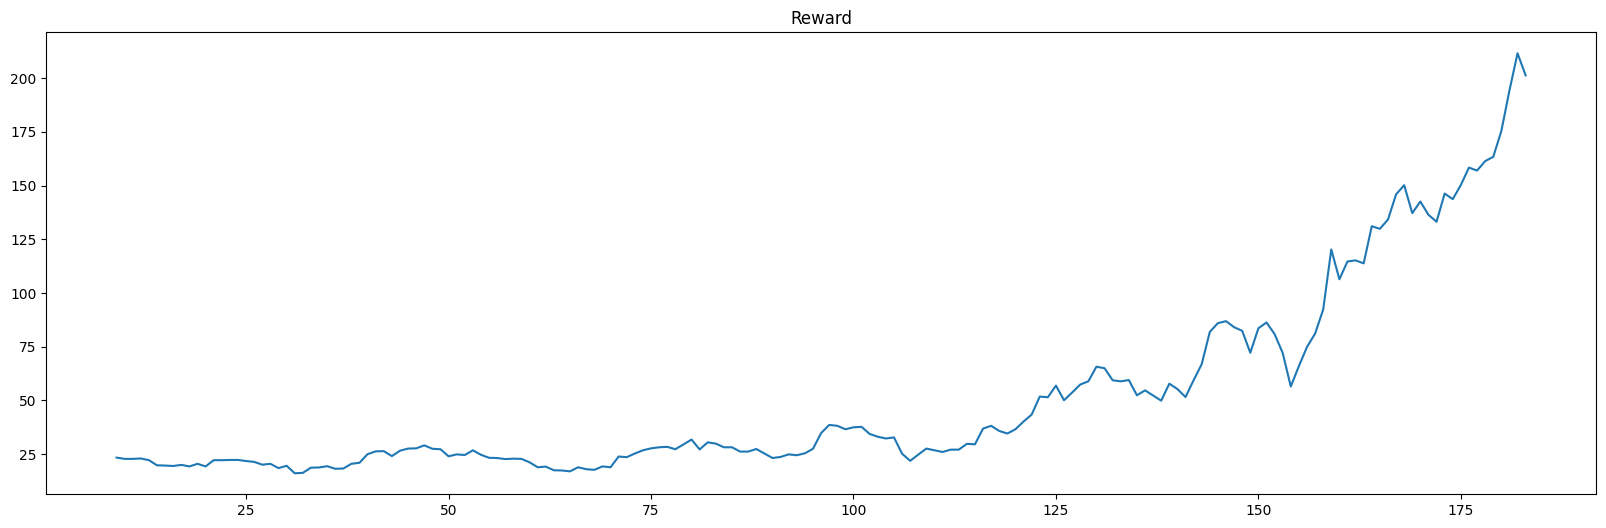

In [9]:
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.lineplot(pd.Series(reward_list).rolling(10).mean())
plt.title("Reward")

Text(0.5, 1.0, 'loss')

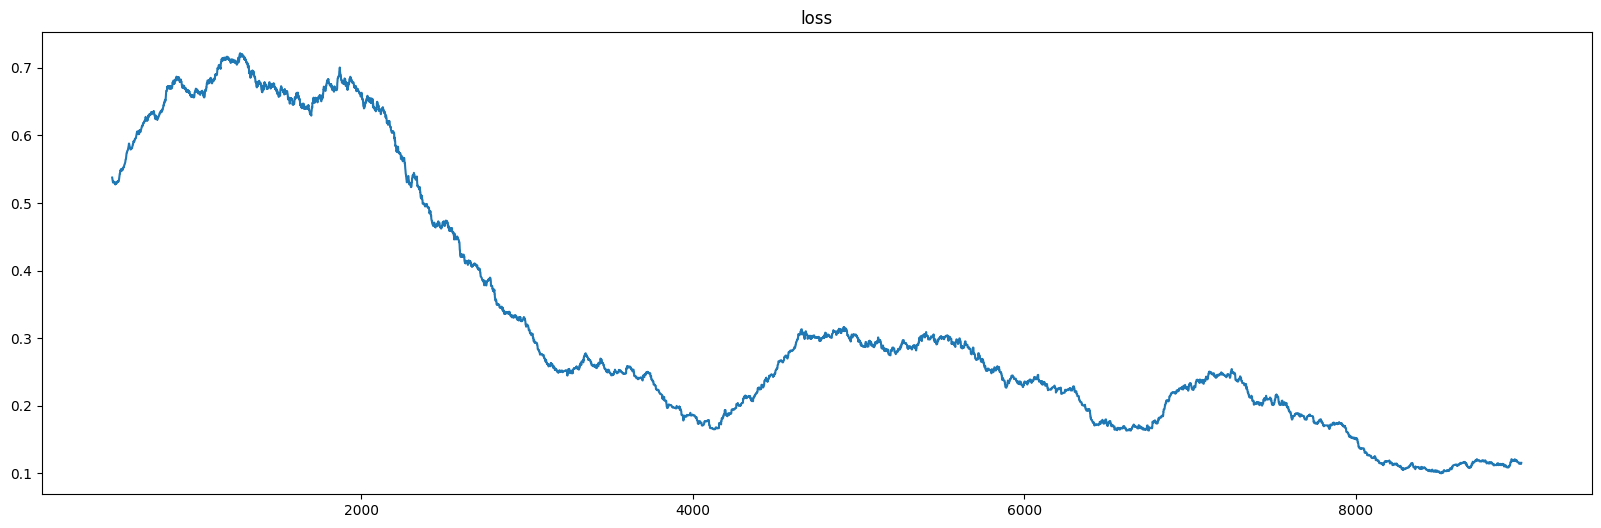

In [10]:
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.lineplot(pd.Series(loss_list).rolling(500).mean())
plt.title("loss")

保存模型

torch.save() - 作用是将对象保存到序列化文件中。

方式一：保存模型 - torch.save(model, ‘./model.pth’) 或者保存一个Python对象- torch.save({‘save’:‘ddd’}, ‘./adict.pth’)

方式二：保存模型参数 - torch.save(model.state_dict(), ‘./model.pth’)

torch.load() - 作用是将序列化文件生成回对象。

加载方式一的模型： model = torch.load(‘./model.pth’)

加载方式二的参数:

​ model = Model()

​ model.load_state_dict(torch.load(‘./model.pth’))


In [11]:
torch.save(dqn.Q,"models/model.bin")

## 读取模型

Q网络起到输入state，输出action的作用

In [12]:
import gymnasium as gym
env = gym.make("CartPole-v1")
env.reset()

(array([ 0.03120299,  0.03202675,  0.03300919, -0.01529417], dtype=float32),
 {})

In [13]:
net=torch.load("models/model.bin",weights_only=False)
net

QNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
net(torch.randn(1,4,device="cuda")).argmax(1)

tensor([0], device='cuda:0')

使用DQN会发现能稳定平衡，但会滑出界

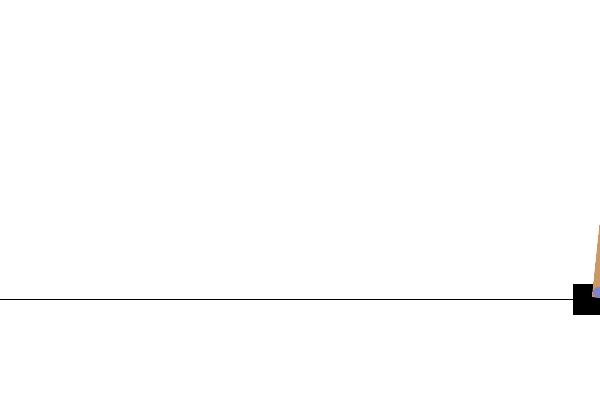

Finished! 最大轮次为： 301


In [17]:
import matplotlib.pylab as plt
from PIL import Image
from IPython.display import display, clear_output
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
for step in range(1000):
    clear_output(wait=True)
    display(Image.fromarray(env.render()))
    state = torch.as_tensor(state, device="cuda").unsqueeze(0)
    action = net(state).argmax(1).item()
    # action=env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print(f"Finished! 最大轮次为：", step)
        break


env.close()